In [2]:
# Hecho por Vladimir

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

data_dir = "../../data/unziped_data/"

In [3]:
df = pd.read_csv(os.path.join(data_dir, "FTP_SABER11_20182.TXT"),
                 sep='¬', header=0, encoding='utf-8-sig')
print(df.shape)

/home/trucupey/.virtualenvs/ICFES-SocioEconomico-u_M2eJSI/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  


(549934, 83)


In [15]:
df_sample = df.sample(n=20000,random_state=2)

In [5]:
[p for p in df_sample.columns.values if 'ESTRATO' in p]

['FAMI_ESTRATOVIVIENDA']

In [6]:
df_sample["INSE"] = pd.qcut(df_sample["ESTU_INSE_INDIVIDUAL"], 3, labels=False)

In [7]:
PUNTAJES = [p for p in df.columns.values if 'PUNT' in p and 'INTERDI' not in p and 'RECAF' not in p and 'ESPERADO' not in p and 'INTERDISC' not in p and 'PROF' not in p]
print(PUNTAJES)

['PUNT_LECTURA_CRITICA', 'PUNT_MATEMATICAS', 'PUNT_C_NATURALES', 'PUNT_SOCIALES_CIUDADANAS', 'PUNT_INGLES', 'PUNT_GLOBAL']


In [16]:
def group_estratos(estrato):
    if estrato == 'Estrato 2' or estrato == 'Estrato 1':
        return 'Estrato 1-2'
    elif estrato == 'Estrato 3' or estrato == 'Estrato 4':
        return 'Estrato 3-4'
    elif estrato == 'Estrato 5' or estrato == 'Estrato 6':
        return 'Estrato 5-6'
    else:
        return np.nan

df_sample['FAMI_ESTRATOVIVIENDA'] = df_sample['FAMI_ESTRATOVIVIENDA'].apply(group_estratos)

def pretty_names(name, puntajes):
    if name in puntajes:
        newname = name.replace("PUNT_", "").replace("_", " ")
    elif '_NSE_INDIVIDUAL' in name:
        newname = 'NSE'
    else:
        newname = name
    return newname

df_sample.columns = [pretty_names(name, PUNTAJES) for name in df_sample.columns.values]
NEWPUNTAJES = [name.replace("PUNT_", "").replace("_", " ") for name in PUNTAJES]

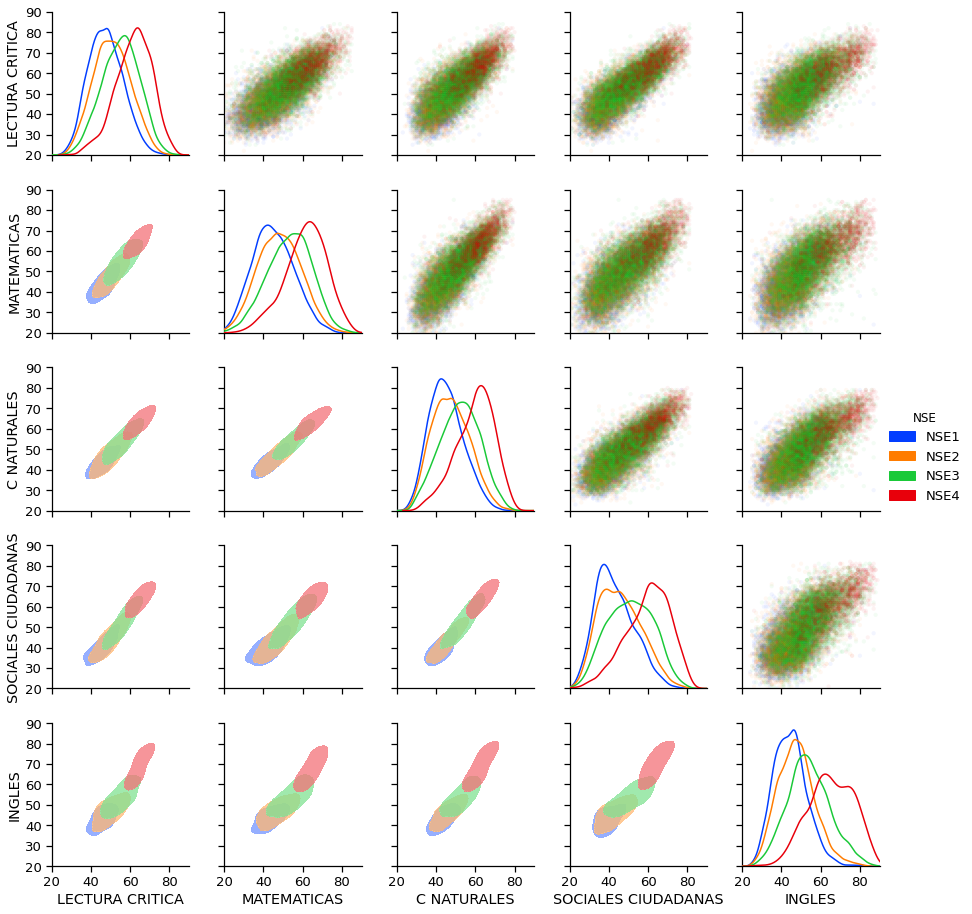

In [21]:
# Make a 2d normed histogram
import numpy as np
import scipy

from itertools import cycle

def make_kde(*args,**kwargs):
    data1 = args[0]
    data2 = args[1]
    H,xedges,yedges=np.histogram2d(data1, data2,bins=30, density=True)
    norm=H.sum() # Find the norm of the sum
    # Set contour levels
    contour1=0.4
    # Set target levels as percentage of norm
    target1 = norm*contour1
    # Take histogram bin membership as proportional to Likelihood
    # This is true when data comes from a Markovian process
    def objective(limit, target):
        w = np.where(H>limit)
        count = H[w]
        return count.sum() - target
    # Find levels by summing histogram to objective
    level1= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target1,))
    # For nice contour shading with seaborn, define top level
    level2=H.max()
    levels=[level1*0.99999**i for i in range(1,25)][::-1] + [level1,level2]
    sns.kdeplot(*args, levels=levels, **kwargs)
    
#make_kde.cmap_cycle = cycle(('coolwarm', 'Wistia', 'icefire'))
cols = np.array(sns.color_palette("bright", 10)[0:4])[[0,1,2,3]]
with sns.plotting_context("notebook", font_scale=1.2):
    g = sns.PairGrid(df_sample.sort_values('NSE'), vars=NEWPUNTAJES[:-1], hue='NSE', palette=cols)
    g = g.map_diag(sns.kdeplot, gridsize=1000)
    g = g.map_upper(sns.scatterplot, alpha=0.05,  edgecolors=None, linewidth=0, size=0.1)
    g = g.map_lower(make_kde, alpha=0.75, gridsize=100, shade=True, shade_lowest=False)
    g.set(ylim=(20, 90), xlim=(20,90))
    g = g.add_legend()
    plt.savefig('estrato_puntajes_descriptivo_20182.png', dpi=300)